## Import the library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score

In [2]:
data=pd.read_csv("/content/Google_Stock_Price_Train.csv")
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [3]:
data['Close']=data['Close'].str.replace(',','').astype(float)
data['Volume']=data['Volume'].str.replace(',','').astype(float)

In [5]:

# Getting a summary of missing values for each field/attribute
print(data.isnull().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


## Handling Outliers

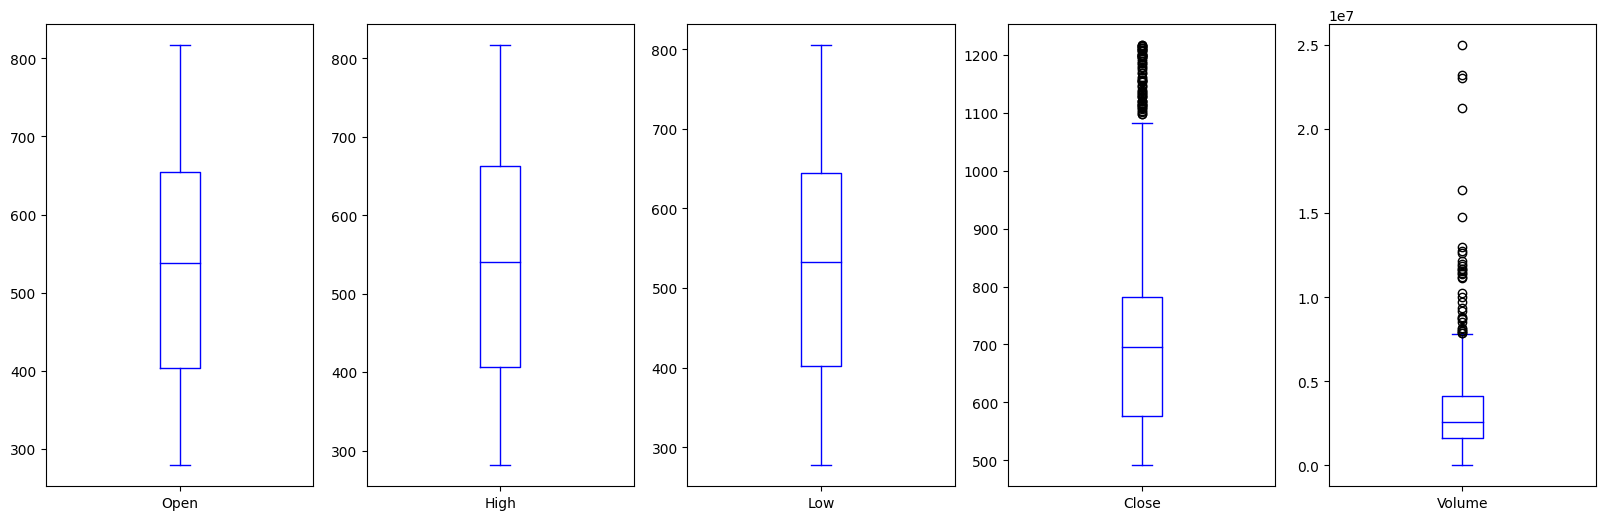

In [6]:
data[['Open','High','Low','Close','Volume']].plot(kind= 'box' ,layout=(1,5),subplots=True, sharex=False, sharey=False, figsize=(20,6),color='blue')
plt.show()


array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>],
       [<Axes: title={'center': 'Volume'}>, <Axes: >]], dtype=object)

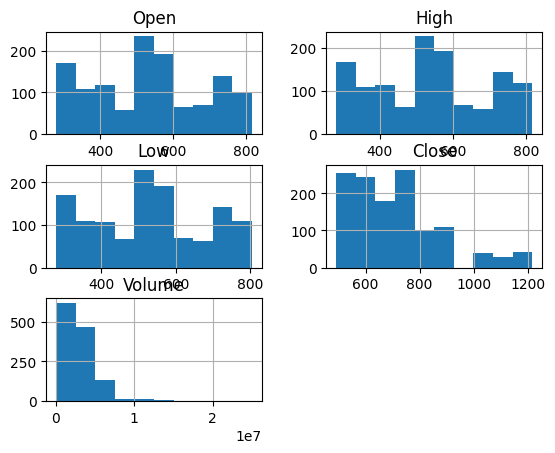

In [7]:

data.hist()

In [8]:
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500.0
1,1/4/2012,331.27,333.87,329.08,666.45,5749400.0
2,1/5/2012,329.83,330.75,326.89,657.21,6590300.0
3,1/6/2012,328.34,328.77,323.68,648.24,5405900.0
4,1/9/2012,322.04,322.29,309.46,620.76,11688800.0
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,623400.0
1254,12/27/2016,790.68,797.86,787.66,791.55,789100.0
1255,12/28/2016,793.70,794.23,783.20,785.05,1153800.0
1256,12/29/2016,783.33,785.93,778.92,782.79,744300.0


In [9]:
scaler = MinMaxScaler()
data_without_date = data[['Open','High','Low','Close','Volume']]
data_scaled = pd.DataFrame(scaler.fit_transform(data_without_date))

In [10]:
data_scaled

,0,1,2,3,4
0,0.085814,0.096401,0.090449,0.237573,0.295258
1,0.097012,0.098344,0.098235,0.241514,0.229936
2,0.094334,0.092517,0.094086,0.228781,0.263612
3,0.091562,0.088819,0.088006,0.216419,0.216179
4,0.079842,0.076718,0.061070,0.178548,0.467797
...,...,...,...,...,...
1253,0.952043,0.955292,0.966169,0.411656,0.024650
1254,0.951633,0.964853,0.966889,0.413916,0.031286
1255,0.957251,0.958074,0.958441,0.404958,0.045891
1256,0.937960,0.942574,0.950333,0.401844,0.029491


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object)

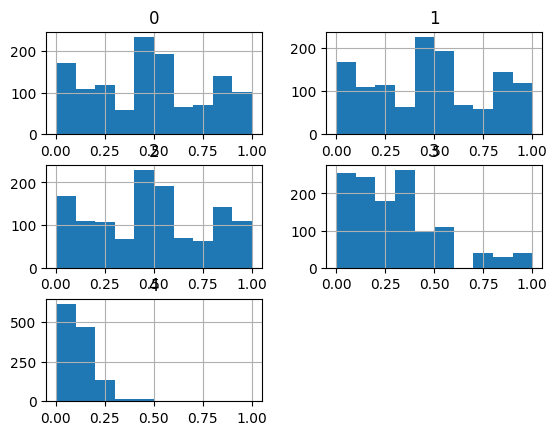

In [11]:



data_scaled.hist()

## Feature Engineering

In [13]:
data_scaled=data_scaled.drop([1,2,4], axis=1)
data_scaled

,0,3
0,0.085814,0.237573
1,0.097012,0.241514
2,0.094334,0.228781
3,0.091562,0.216419
4,0.079842,0.178548
...,...,...
1253,0.952043,0.411656
1254,0.951633,0.413916
1255,0.957251,0.404958
1256,0.937960,0.401844


## Developing the RNN Model

In [14]:
def split_seq_multivariate(sequence, n_past, n_future):

    '''
    n_past ==> no of past observations
    n_future ==> no of future observations
    '''
    x, y = [], []
    for window_start in range(len(sequence)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(sequence):
            break
        # slicing the past and future parts of the window
        past   = sequence[window_start:past_end, :]
        future = sequence[past_end:future_end, -1]
        x.append(past)
        y.append(future)

    return np.array(x), np.array(y)


In RNN, since we are dealing with time series data, we have to specify how many past data points we will be considering when generating the sequence.

In here, i have taken 60 past data points (time steps) when generating the data sequences.

In [15]:

# specify the window size
n_steps = 60

data_scaled = data_scaled.to_numpy()
data_scaled.shape

(1258, 2)

Next, I am using the split_seq_multivariate function to split the dataset into sequences.

In [16]:

# split into samples
X, y = split_seq_multivariate(data_scaled, n_steps,1)

In [17]:
X[1].shape

(60, 2)

In [18]:
y

array([[0.21420007],
       [0.20434657],
       [0.21216047],
       ...,
       [0.40495845],
       [0.40184391],
       [0.38672602]])

In [19]:

# X is in the shape of [samples, timesteps, features]
print(X.shape)
print(y.shape)

# make y to the shape of [samples]
y=y[:,0]
y.shape


(1198, 60, 2)
(1198, 1)


(1198,)

## Splitting the Data

In this step, splitting the sequenced data into train and test sections with 0.2 test size.

Split the training set again to train and validation data. I have not used the test data to do the validation because validation data are used to fine tune the model, and if i used the testing data for validation purposes, then those data will be already seen by the model when trying to predict them later.


In [20]:

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=50)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(958, 60, 2) (240, 60, 2) (958,) (240,)


In [21]:
# further dividing the training set into train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=30)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(766, 60, 2) (192, 60, 2) (766,) (192,)


## Define Model

Defining the model using Tensorflow Keras LSTM and Dense layers.

In the LSTM layer, not specified the activation function explicitly because in the Keras Documentation it is specified that the default activation function for LSTM is tanh and default recurrent activation function is sigmoid. Therefore those default acivation functions will be used here.

In [22]:
# define RNN model
model = Sequential()
model.add(LSTM(612, input_shape=(n_steps,2)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))

The following code line gives a summary of the model we have created, mentioning each layers information.

In [23]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 612)               1505520   
                                                                 
 dense (Dense)               (None, 50)                30650     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1540281 (5.88 MB)
Trainable params: 1540281 (5.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compiling and Training the Model

In [24]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [25]:
# fit the model
history = model.fit(X_train, y_train, epochs=250, batch_size=32, verbose=2, validation_data=(X_val, y_val))  # has used mini batch learning, with batch_s

Epoch 1/250
24/24 - 5s - loss: 0.0646 - mae: 0.1744 - val_loss: 0.0144 - val_mae: 0.0924 - 5s/epoch - 212ms/step
Epoch 2/250
24/24 - 0s - loss: 0.0087 - mae: 0.0656 - val_loss: 0.0050 - val_mae: 0.0397 - 324ms/epoch - 13ms/step
Epoch 3/250
24/24 - 0s - loss: 0.0037 - mae: 0.0326 - val_loss: 0.0038 - val_mae: 0.0271 - 321ms/epoch - 13ms/step
Epoch 4/250
24/24 - 0s - loss: 0.0030 - mae: 0.0286 - val_loss: 0.0041 - val_mae: 0.0365 - 329ms/epoch - 14ms/step
Epoch 5/250
24/24 - 0s - loss: 0.0027 - mae: 0.0275 - val_loss: 0.0038 - val_mae: 0.0359 - 352ms/epoch - 15ms/step
Epoch 6/250
24/24 - 0s - loss: 0.0028 - mae: 0.0302 - val_loss: 0.0035 - val_mae: 0.0304 - 352ms/epoch - 15ms/step
Epoch 7/250
24/24 - 0s - loss: 0.0025 - mae: 0.0268 - val_loss: 0.0037 - val_mae: 0.0351 - 323ms/epoch - 13ms/step
Epoch 8/250
24/24 - 0s - loss: 0.0020 - mae: 0.0244 - val_loss: 0.0024 - val_mae: 0.0243 - 335ms/epoch - 14ms/step
Epoch 9/250
24/24 - 0s - loss: 0.0019 - mae: 0.0227 - val_loss: 0.0027 - val_mae: 

In [27]:

# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, np.sqrt(mse), mae))

MSE: 0.001, RMSE: 0.024, MAE: 0.018


In [28]:

# predicting y_test values
print(X_test.shape)
predicted_values = model.predict(X_test)
print(predicted_values.shape)
# print(predicted_values)


(240, 60, 2)
8/8 [==============================] - 0s 7ms/step
(240, 1)


<Figure size 1000x600 with 0 Axes>

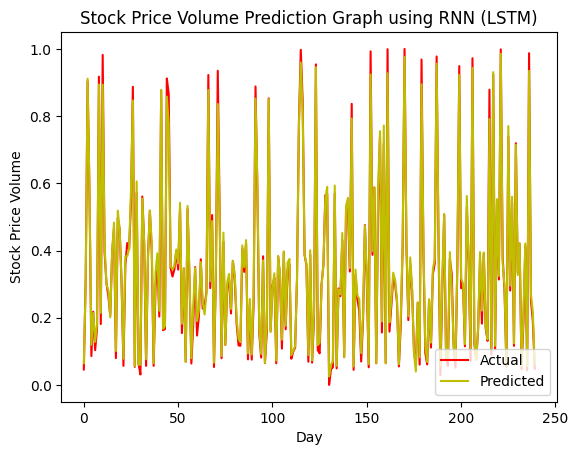

<Figure size 1000x600 with 0 Axes>

In [29]:

plt.plot(y_test,c = 'r')
plt.plot(predicted_values,c = 'y')
plt.xlabel('Day')
plt.ylabel('Stock Price Volume')
plt.title('Stock Price Volume Prediction Graph using RNN (LSTM)')
plt.legend(['Actual','Predicted'],loc = 'lower right')
plt.figure(figsize=(10,6))


In [30]:

# evaluating using R squared
R_square = r2_score(y_test, predicted_values)

print(R_square)

0.9916050904207924
